In [ ]:
!pip install pandas requests beautifulsoup4 tqdm

# Ver1 Oct 9th

In [ ]:
import pandas as pd
import requests
from urllib.parse import urljoin
from bs4 import BeautifulSoup
import concurrent.futures
import logging
from tqdm import tqdm
import time
import random

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class EthicalSocialMediaChecker:
    def __init__(self):
        self.social_media_patterns = {
            'sm_fb': ['facebook.com', 'fb.com'],
            'sm_linkedin': ['linkedin.com'],
            'sm_x': ['twitter.com', 'x.com'],
            'sm_insta': ['instagram.com'],
            'sm_tiktok': ['tiktok.com'],
            'sm_yt': ['youtube.com']
        }
        # Ethical user agent string
        self.headers = {
            'User-Agent': 'Ethical Web Scraper/1.0 (Educational Project; Contact: roshna.omer@gmail.com)'
        }

    def check_url(self, row):
        url = row['url']
        if not url.startswith(('http://', 'https://')):
            url = 'https://' + url

        try:
            # Random delay between requests (1 to 3 seconds)
            time.sleep(random.uniform(1, 3))

            # First, check for robots.txt
            robots_url = urljoin(url, '/robots.txt')
            try:
                robots_response = requests.get(robots_url, headers=self.headers, timeout=5)
                if 'disallow: /' in robots_response.text.lower():
                    logging.info(f"Respecting robots.txt disallow for {url}")
                    return self.create_empty_result(row)
            except Exception:
                # If we can't check robots.txt, we'll proceed cautiously
                pass

            response = requests.get(url, headers=self.headers, timeout=10)
            soup = BeautifulSoup(response.text, 'html.parser')

            results = {
                'id': row['id'],
                'url': row['url'],
                'country': row['country'],
                'ecommerce': row['ecommerce']
            }

            # Only look for social media links in the footer or header
            potential_sections = soup.find_all(['header', 'footer'])
            links = []
            for section in potential_sections:
                links.extend([a.get('href', '') for a in section.find_all('a', href=True)])

            # Check each social media platform
            for platform, patterns in self.social_media_patterns.items():
                found = 0
                for link in links:
                    if any(pattern in link.lower() for pattern in patterns):
                        found = 1
                        break
                results[platform] = found

            return results

        except Exception as e:
            logging.error(f"Error processing {url}: {str(e)}")
            return self.create_empty_result(row)

    def create_empty_result(self, row):
        return {
            'id': row['id'],
            'url': row['url'],
            'country': row['country'],
            'ecommerce': row['ecommerce'],
            **{platform: 0 for platform in self.social_media_patterns.keys()}
        }

def process_csv(input_file, output_file, max_workers=3):
    # Read the CSV file
    df = pd.read_csv(input_file)

    checker = EthicalSocialMediaChecker()
    results = []

    # Limit the number of concurrent requests
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(checker.check_url, row) for _, row in df.iterrows()]

        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
            result = future.result()
            if result:
                results.append(result)

    # Create results DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_file, index=False)
    logging.info(f"Results saved to {output_file}")

if __name__ == "__main__":
    input_file = 'input.csv'
    output_file = 'results.csv'
    process_csv(input_file, output_file)

100%|██████████| 4000/4000 [1:19:26<00:00,  1.19s/it]


In [ ]:
!pip install matplotlib

Total websites analyzed: 4000
Websites with no social media: 3327 (83.2%)
Websites with at least one social media: 673 (16.8%)

Distribution of social media platforms per website:
0 platforms: 3327 websites (83.2%)
1 platforms: 116 websites (2.9%)
2 platforms: 262 websites (6.6%)
3 platforms: 161 websites (4.0%)
4 platforms: 90 websites (2.2%)
5 platforms: 39 websites (1.0%)
6 platforms: 5 websites (0.1%)

Popularity of each platform:
sm_fb: 610 websites (15.2%)
sm_linkedin: 207 websites (5.2%)
sm_x: 104 websites (2.6%)
sm_insta: 519 websites (13.0%)
sm_tiktok: 57 websites (1.4%)
sm_yt: 211 websites (5.3%)


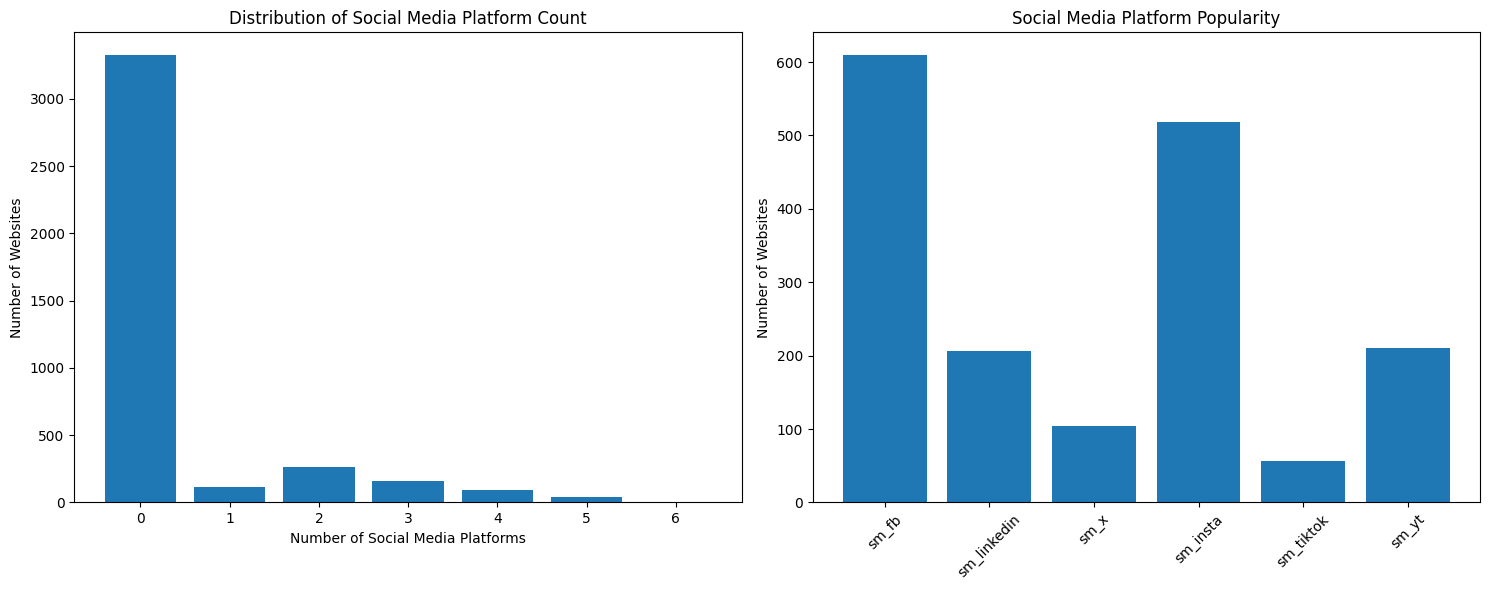

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def analyze_results(csv_file):
    # Read the CSV file
    df = pd.read_csv(csv_file)

    # List of social media columns
    social_media_cols = ['sm_fb', 'sm_linkedin', 'sm_x', 'sm_insta', 'sm_tiktok', 'sm_yt']

    # Calculate the sum of social media presence for each website
    df['total_sm_count'] = df[social_media_cols].sum(axis=1)

    # Count websites by number of social media platforms
    sm_distribution = Counter(df['total_sm_count'])

    # Calculate total websites
    total_websites = len(df)

    # Calculate websites with no social media
    no_sm = sm_distribution[0]

    # Calculate websites with at least one social media
    has_sm = total_websites - no_sm

    # Create a summary dictionary
    summary = {
        'total_websites': total_websites,
        'no_social_media': no_sm,
        'has_social_media': has_sm,
        'distribution': {i: sm_distribution[i] for i in range(7)},
        'platform_stats': {col: int(df[col].sum()) for col in social_media_cols}
    }

    return df, summary

def print_summary(summary):
    print(f"Total websites analyzed: {summary['total_websites']}")
    print(f"Websites with no social media: {summary['no_social_media']} ({summary['no_social_media']/summary['total_websites']*100:.1f}%)")
    print(f"Websites with at least one social media: {summary['has_social_media']} ({summary['has_social_media']/summary['total_websites']*100:.1f}%)")

    print("\nDistribution of social media platforms per website:")
    for num, count in summary['distribution'].items():
        percentage = count/summary['total_websites']*100
        print(f"{num} platforms: {count} websites ({percentage:.1f}%)")

    print("\nPopularity of each platform:")
    for platform, count in summary['platform_stats'].items():
        percentage = count/summary['total_websites']*100
        print(f"{platform}: {count} websites ({percentage:.1f}%)")

def plot_summary(df, summary):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Distribution of number of social media platforms
    platforms = list(summary['distribution'].keys())
    counts = list(summary['distribution'].values())
    ax1.bar(platforms, counts)
    ax1.set_xlabel('Number of Social Media Platforms')
    ax1.set_ylabel('Number of Websites')
    ax1.set_title('Distribution of Social Media Platform Count')

    # Plot 2: Platform popularity
    platforms = list(summary['platform_stats'].keys())
    counts = list(summary['platform_stats'].values())
    ax2.bar(platforms, counts)
    ax2.set_xticks(range(len(platforms)))
    ax2.set_xticklabels(platforms, rotation=45)
    ax2.set_ylabel('Number of Websites')
    ax2.set_title('Social Media Platform Popularity')

    plt.tight_layout()
    return fig

# Load and analyze data
df, summary = analyze_results('results.csv')

# Print text summary
print_summary(summary)

# Show plots
fig = plot_summary(df, summary)

# Updated Code Oct 10th

## Processor

In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import concurrent.futures
import logging
import time
import random
import re
from tqdm import tqdm
from urllib.parse import urljoin, urlparse

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class EnhancedWebChecker:
    def __init__(self):
        self.social_media_patterns = {
            'sm_fb': {
                'patterns': ['facebook.com', 'fb.com'],
                'validation_url': 'https://www.facebook.com/'
            },
            'sm_linkedin': {
                'patterns': ['linkedin.com/company'],
                'validation_url': 'https://www.linkedin.com/company/'
            },
            'sm_x': {
                'patterns': ['twitter.com', 'x.com'],
                'validation_url': 'https://twitter.com/'
            },
            'sm_insta': {
                'patterns': ['instagram.com'],
                'validation_url': 'https://www.instagram.com/'
            },
            'sm_tiktok': {
                'patterns': ['tiktok.com'],
                'validation_url': 'https://www.tiktok.com/@'
            },
            'sm_yt': {
                'patterns': ['youtube.com/channel', 'youtube.com/c/', 'youtube.com/user'],
                'validation_url': 'https://www.youtube.com/channel/'
            }
        }

        self.ecommerce_indicators = {
            'payment_options': [
                'payment', 'checkout', 'shopping cart', 'add to cart', 'buy now',
                'credit card', 'paypal', 'stripe', 'klarna', 'purchase'
            ],
            'shopping_elements': [
                'shopping bag', 'basket', 'cart', 'checkout', 'shop now',
                'product catalog', 'order now', 'book now', 'subscribe now'
            ],
            'pricing': [
                r'\$\d+', r'€\d+', r'£\d+', r'\d+\s*USD', r'\d+\s*EUR', r'\d+\s*GBP',
                'pricing', 'price list', 'subscription plan'
            ],
            'ecommerce_platforms': [
                'shopify', 'woocommerce', 'magento', 'prestashop', 'opencart',
                'bigcommerce', 'squarespace commerce'
            ],
            'booking_services': [
                'book a room', 'reserve a table', 'book a ticket', 'book appointment',
                'booking system', 'reservation system'
            ],
            'subscription_services': [
                'subscription', 'monthly plan', 'annual plan', 'free trial',
                'start your subscription', 'choose your plan'
            ]
        }

        self.headers = {
            'User-Agent': 'Ethical Web Scraper for WIN Hackathon/1.0 (Educational Project; Contact: your@email.com)'
        }

    def check_robots_txt(self, base_url):
        try:
            robots_url = urljoin(base_url, '/robots.txt')
            response = requests.get(robots_url, headers=self.headers, timeout=5)
            return 'disallow: /' in response.text.lower()
        except Exception:
            return False

    def validate_social_media_link(self, url, platform_data):
        try:
            response = requests.head(url, headers=self.headers, timeout=5, allow_redirects=True)
            return response.status_code == 200
        except Exception:
            return False

    def find_ecommerce_indicators(self, soup, url):
        text = soup.get_text().lower()

        # Check for various e-commerce indicators
        indicators_found = {
            'payment': any(indicator in text for indicator in self.ecommerce_indicators['payment_options']),
            'shopping': any(indicator in text for indicator in self.ecommerce_indicators['shopping_elements']),
            'pricing': any(re.search(pattern, text) for pattern in self.ecommerce_indicators['pricing']),
            'platform': any(platform in str(soup).lower() for platform in self.ecommerce_indicators['ecommerce_platforms']),
            'booking': any(indicator in text for indicator in self.ecommerce_indicators['booking_services']),
            'subscription': any(indicator in text for indicator in self.ecommerce_indicators['subscription_services'])
        }

        # Look for forms that might indicate e-commerce
        forms = soup.find_all('form')
        for form in forms:
            action = form.get('action', '').lower()
            if any(term in action for term in ['cart', 'checkout', 'payment', 'order']):
                indicators_found['form'] = True
                break

        # Count how many types of indicators were found
        indicator_count = sum(indicators_found.values())

        # Decision logic
        if indicator_count >= 2:  # If at least two types of indicators are found
            return 1
        elif indicator_count == 1 and (indicators_found['payment'] or indicators_found['platform']):
            return 1  # If only one indicator but it's a strong one
        return 0

    def check_url(self, row):
        url = row['url']
        if not url.startswith(('http://', 'https://')):
            url = 'https://' + url

        base_url = urljoin(url, '/')
        unshortener = URLUnshortener()

        try:
            if self.check_robots_txt(base_url):
                logging.info(f"Respecting robots.txt disallow for {url}")
                return self.create_empty_result(row)

            time.sleep(random.uniform(1, 3))
            response = requests.get(url, headers=self.headers, timeout=10)
            soup = BeautifulSoup(response.text, 'html.parser')

            results = {
                'id': row['id'],
                'url': row['url'],
                'country': row['country']
            }

            # E-commerce detection
            results['ecommerce'] = self.find_ecommerce_indicators(soup, url)

            # Social media detection with URL unshortening
            all_links = [a.get('href', '') for a in soup.find_all('a', href=True)]
            for platform, data in self.social_media_patterns.items():
                found = 0
                for link in all_links:
                    # Handle relative URLs
                    if not link.startswith(('http://', 'https://')):
                        link = urljoin(base_url, link)

                    # Unshorten URL if necessary
                    if unshortener.is_shortened_url(link):
                        unshortened_link = unshortener.unshorten_url(link)
                        if any(pattern in unshortened_link.lower() for pattern in data['patterns']):
                            if self.validate_social_media_link(unshortened_link, data):
                                found = 1
                                break
                    elif any(pattern in link.lower() for pattern in data['patterns']):
                        if self.validate_social_media_link(link, data):
                            found = 1
                            break
                results[platform] = found

            return results

        except Exception as e:
            logging.error(f"Error processing {url}: {str(e)}")
            return self.create_empty_result(row)

    def create_empty_result(self, row):
        return {
            'id': row['id'],
            'url': row['url'],
            'country': row['country'],
            'ecommerce': 0,
            **{platform: 0 for platform in self.social_media_patterns.keys()}
        }

def process_csv(input_file, output_file, max_workers=3):
    df = pd.read_csv(input_file)
    checker = EnhancedWebChecker()
    results = []

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(checker.check_url, row) for _, row in df.iterrows()]


        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
            result = future.result()
            if result:
                results.append(result)

        # for future in concurrent.futures.as_completed(futures):
        #     result = future.result()
        #     if result:
        #         results.append(result)

    results_df = pd.DataFrame(results)
    results_df.to_csv(output_file, index=False)
    logging.info(f"Results saved to {output_file}")

# if __name__ == "__main__":

In [3]:
class URLUnshortener:
    def __init__(self):
        self.shortener_domains = {
            'bit.ly', 'tinyurl.com', 't.co', 'goo.gl', 'ow.ly', 'is.gd',
            'buff.ly', 'adf.ly', 'bit.do', 'mcaf.ee', 'su.pr', 'dlvr.it'
        }

    def is_shortened_url(self, url):
        try:
            domain = urlparse(url).netloc.lower()
            return any(shortener in domain for shortener in self.shortener_domains)
        except:
            return False

    def unshorten_url(self, url):
        try:
            if not self.is_shortened_url(url):
                return url

            response = requests.head(url, allow_redirects=True, timeout=5)
            return response.url
        except Exception as e:
            logging.warning(f"Failed to unshorten URL {url}: {str(e)}")
            return url


In [4]:

input_file = 'input.csv'
output_file = 'results.csv'

In [5]:

process_csv(input_file, output_file)

 23%|██▎       | 931/4000 [14:14<46:41,  1.10it/s]WARNING:root:Failed to unshorten URL http://hotel-wiesbaden.dorint.com/de/bewertungen?etcc_cmp_onsite=Wiesbaden-Nav-Bewertungen&etcc_cu=onsite&etcc_med_onsite=Hotelnavigation&cHash=e1faa909563074393e3bc516b5942a9f: HTTPSConnectionPool(host='hotel-wiesbaden.dorint.com', port=443): Read timed out. (read timeout=5)
ERROR:root:Error processing https://www.kebo.de: HTTPSConnectionPool(host='www.kebo.de', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)')))
 49%|████▉     | 1970/4000 [40:18<24:22,  1.39it/s]WARNING:root:Failed to unshorten URL https://dorint.com/de/occidental-punta-cana: HTTPSConnectionPool(host='dorint.com', port=443): Read timed out. (read timeout=5)
ERROR:root:Error processing http://www.sultan.restaurant: HTTPSConnectionPool(host='www.sultan.restaurant', port=443): Max retries excee

## Analyzer

Total websites analyzed: 4000

E-commerce Analysis:
Total websites with e-commerce: 260 (6.5%)

By Country Analysis:

DE:
  Total websites: 1000
  E-commerce presence: 49 (4.9%)
  Average social media platforms: 0.33

NL:
  Total websites: 1000
  E-commerce presence: 79 (7.9%)
  Average social media platforms: 0.48

PL:
  Total websites: 1000
  E-commerce presence: 58 (5.8%)
  Average social media platforms: 0.31

AT:
  Total websites: 1000
  E-commerce presence: 74 (7.4%)
  Average social media platforms: 0.37

Social Media Platform Popularity:
sm_fb: 940 websites (23.5%)
sm_linkedin: 246 websites (6.2%)
sm_x: 15 websites (0.4%)
sm_insta: 66 websites (1.7%)
sm_tiktok: 6 websites (0.1%)
sm_yt: 213 websites (5.3%)

Correlation between E-commerce and Social Media:
sm_fb: 0.289
sm_linkedin: 0.122
sm_x: -0.016
sm_insta: 0.117
sm_tiktok: 0.042
sm_yt: 0.073


<ipython-input-6-61b6023058d3>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(platforms, rotation=45)


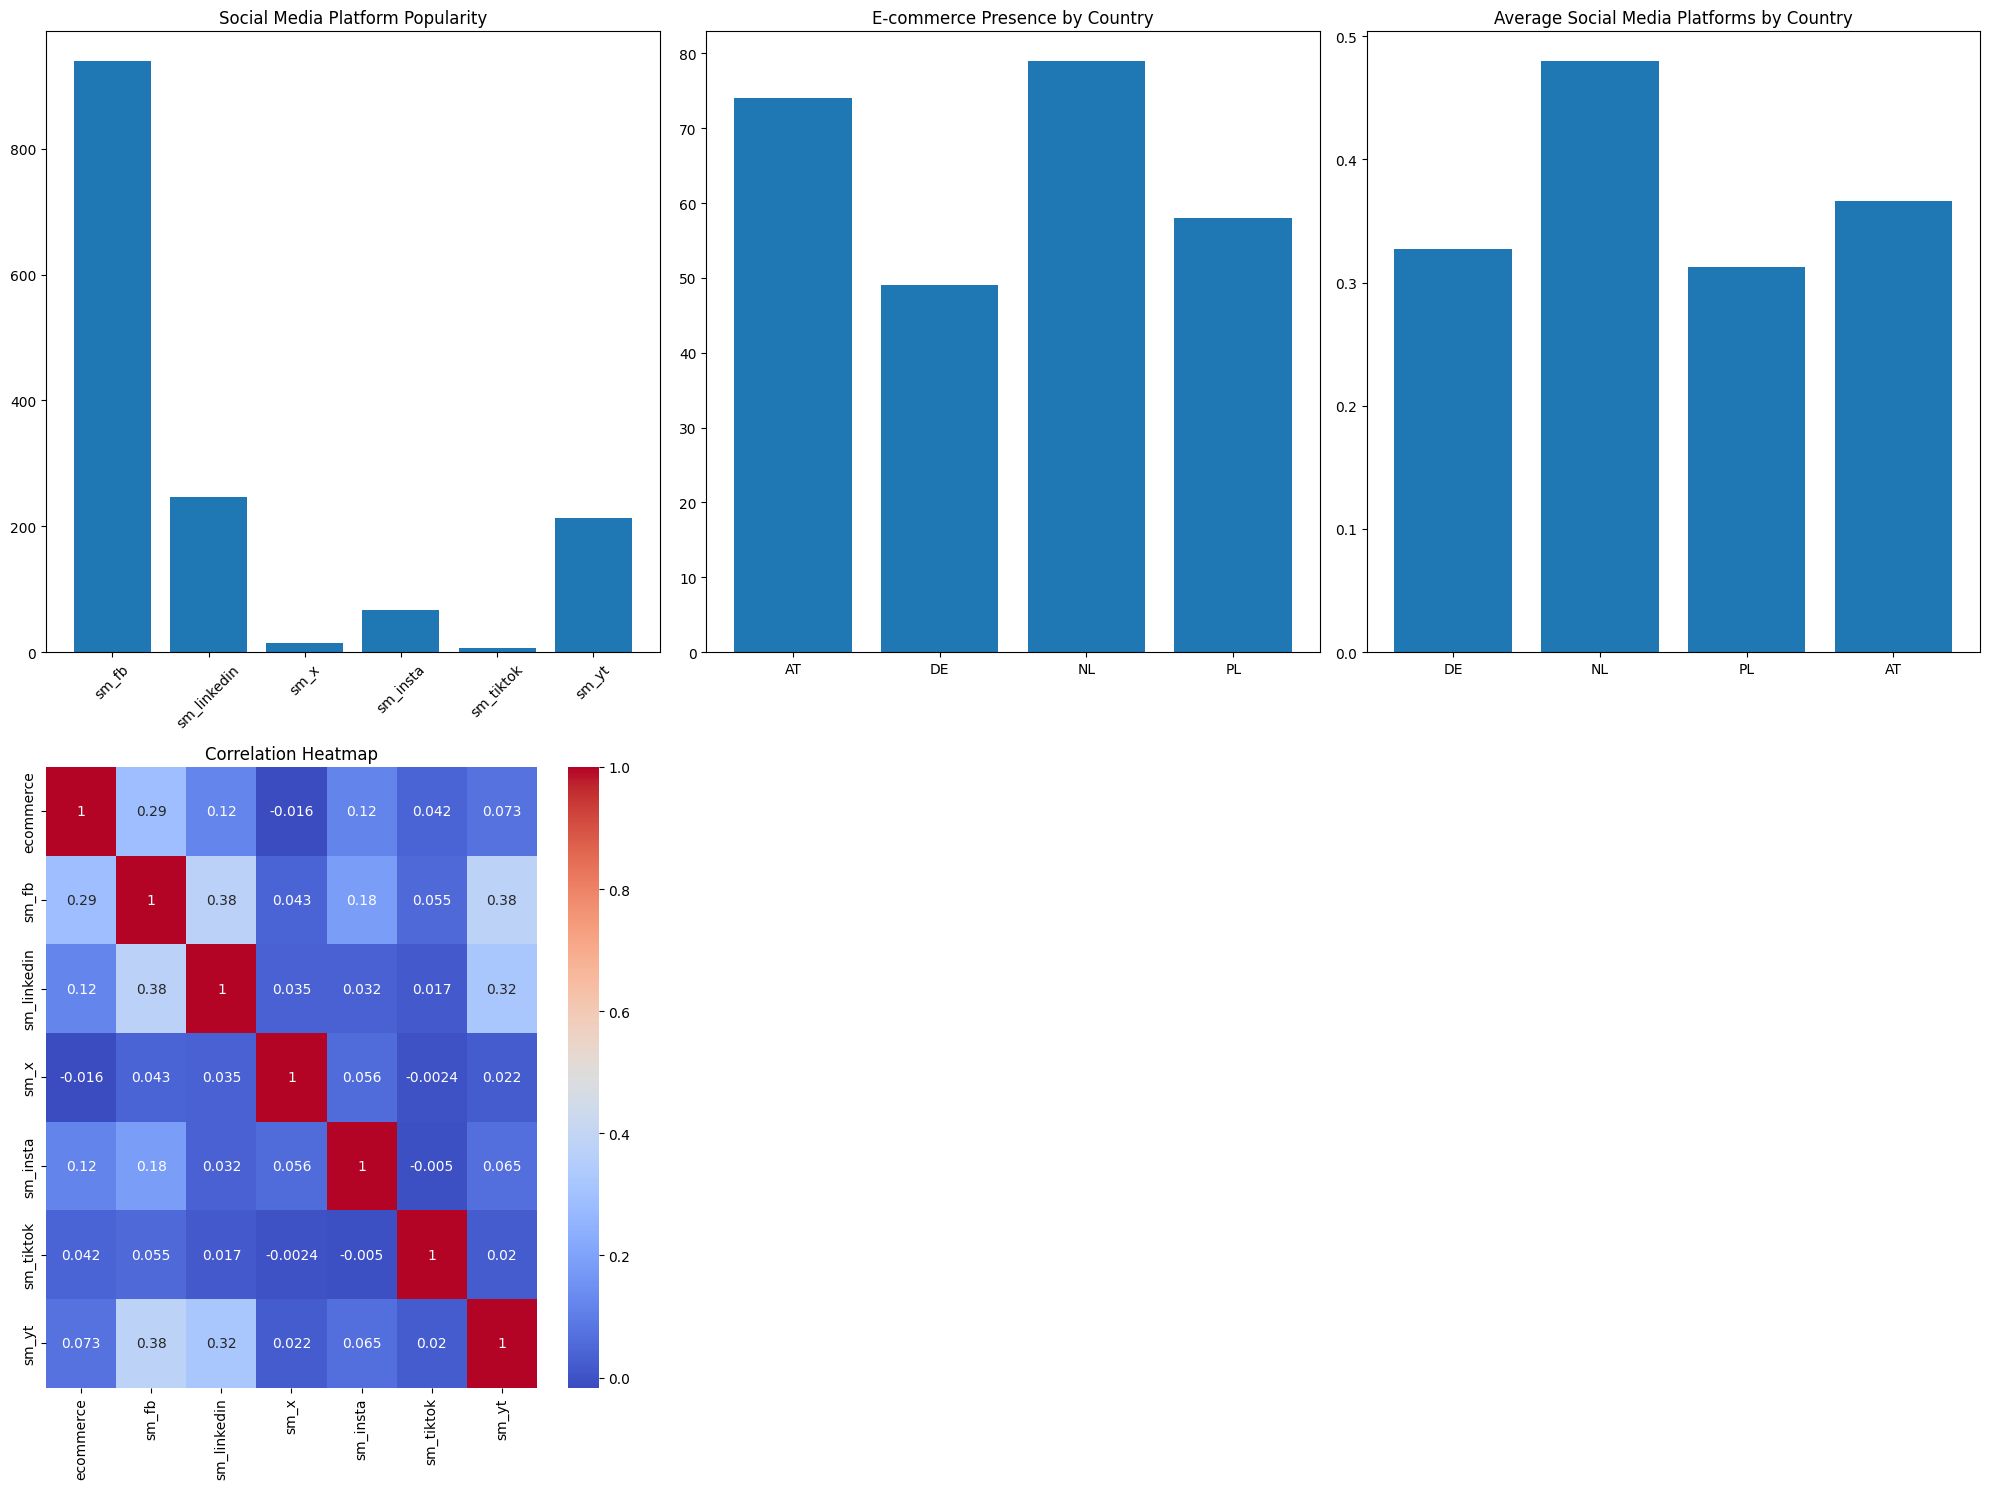

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from collections import Counter, defaultdict

def analyze_results(csv_file):
    # Read the CSV file
    df = pd.read_csv(csv_file)

    # List of social media columns and other indicators
    social_media_cols = ['sm_fb', 'sm_linkedin', 'sm_x', 'sm_insta', 'sm_tiktok', 'sm_yt']

    # Calculate the sum of social media presence for each website
    df['total_sm_count'] = df[social_media_cols].sum(axis=1)

    # Create summary dictionary
    summary = {
        'total_websites': len(df),
        'by_country': {},
        'ecommerce': {
            'total': int(df['ecommerce'].sum()),
            'by_country': df.groupby('country')['ecommerce'].sum().to_dict()
        },
        'social_media': {
            'distribution': Counter(df['total_sm_count']),
            'by_platform': {col: int(df[col].sum()) for col in social_media_cols},
            'by_country': {
                country: {col: int(group[col].sum()) for col in social_media_cols}
                for country, group in df.groupby('country')
            }
        },
        'correlations': {
            'ecommerce_vs_social': calculate_correlations(df, 'ecommerce', social_media_cols)
        }
    }

    # Add country-specific statistics
    for country in df['country'].unique():
        country_data = df[df['country'] == country]
        summary['by_country'][country] = {
            'total_websites': len(country_data),
            'ecommerce_count': int(country_data['ecommerce'].sum()),
            'avg_social_media': float(country_data['total_sm_count'].mean()),
            'social_media_distribution': Counter(country_data['total_sm_count'])
        }

    return df, summary

def calculate_correlations(df, target_col, feature_cols):
    correlations = {}
    for col in feature_cols:
        correlations[col] = float(df[target_col].corr(df[col]))
    return correlations

def print_summary(summary):
    print(f"Total websites analyzed: {summary['total_websites']}")

    print("\nE-commerce Analysis:")
    print(f"Total websites with e-commerce: {summary['ecommerce']['total']} "
          f"({summary['ecommerce']['total']/summary['total_websites']*100:.1f}%)")

    print("\nBy Country Analysis:")
    for country, data in summary['by_country'].items():
        print(f"\n{country}:")
        print(f"  Total websites: {data['total_websites']}")
        print(f"  E-commerce presence: {data['ecommerce_count']} "
              f"({data['ecommerce_count']/data['total_websites']*100:.1f}%)")
        print(f"  Average social media platforms: {data['avg_social_media']:.2f}")

    print("\nSocial Media Platform Popularity:")
    for platform, count in summary['social_media']['by_platform'].items():
        percentage = count/summary['total_websites']*100
        print(f"{platform}: {count} websites ({percentage:.1f}%)")

    print("\nCorrelation between E-commerce and Social Media:")
    for platform, corr in summary['correlations']['ecommerce_vs_social'].items():
        print(f"{platform}: {corr:.3f}")

def plot_summary(df, summary):
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))

    # 1. Overall Social Media Distribution
    ax1 = plt.subplot(231)
    platforms = list(summary['social_media']['by_platform'].keys())
    counts = list(summary['social_media']['by_platform'].values())
    ax1.bar(platforms, counts)
    ax1.set_xticklabels(platforms, rotation=45)
    ax1.set_title('Social Media Platform Popularity')

    # 2. E-commerce by Country
    ax2 = plt.subplot(232)
    countries = list(summary['ecommerce']['by_country'].keys())
    e_counts = list(summary['ecommerce']['by_country'].values())
    ax2.bar(countries, e_counts)
    ax2.set_title('E-commerce Presence by Country')

    # 3. Social Media Distribution by Country
    ax3 = plt.subplot(233)
    country_avg = {country: data['avg_social_media']
                  for country, data in summary['by_country'].items()}
    ax3.bar(country_avg.keys(), country_avg.values())
    ax3.set_title('Average Social Media Platforms by Country')

    # 4. Correlation Heatmap
    ax4 = plt.subplot(234)
    corr_matrix = df[['ecommerce'] + list(summary['social_media']['by_platform'].keys())].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax4)
    ax4.set_title('Correlation Heatmap')

    plt.tight_layout()
    return fig

if __name__ == "__main__":
    # Analyze results
    df, summary = analyze_results('results.csv')

    # Print text summary
    print_summary(summary)

    # Create and show plots
    fig = plot_summary(df, summary)
    plt.show()